# 05 — Input/Output and Architecture Decisions

Purpose: learn how to decide inputs/outputs and choose depth/width by reasoning about shapes, parameter counts, and the geometry you need (linear vs non-linear boundaries).

## Learning goals
- Translate problem requirements into input/output shapes.
- Compare architectures by parameter count and representational capacity.
- See the practical effect of depth/width on decision boundaries (fixed, random weights).
- Learn the habit: pick the smallest model that meets the requirement, then iterate.

## Prerequisites
- Notebook 02 (composition).
- Notebook 04 (classification vs regression).
- Comfort with matrix shapes.

## Key ideas
- Outputs are an interface: regression uses real-valued outputs; classification uses logits/probabilities.
- Depth and width change capacity differently.
- Parameter count is a first-order proxy for overfitting risk (not the whole story).
- Start with 2D when possible to visualize and debug the geometry.

## Minimal theory
- Dense layer parameters: `W` has shape `(D_in, D_out)`, `b` has shape `(1, D_out)`.
- Parameter count: `D_in*D_out + D_out`.
- For a simple MLP: `x -> (D->H) -> (H->C)` totals `(D*H+H) + (H*C+C)` parameters.
- More parameters can fit more complex functions, but can also memorize noise.

x shape: (700, 2) y shape: (700, 1)


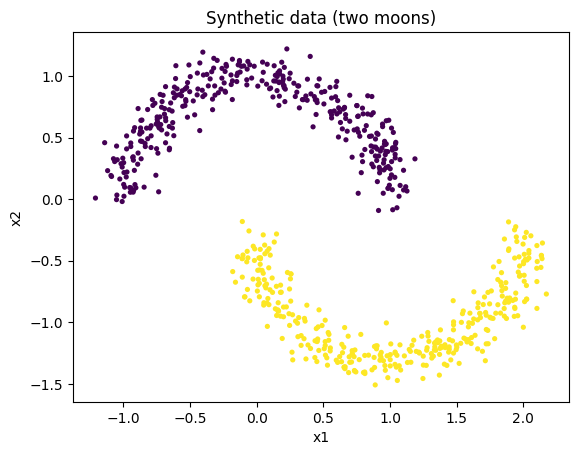

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def relu(z):
    return np.maximum(0.0, z)

def make_two_moons(N=600, noise=0.10, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    # Two interleaving half circles (toy)
    n = N // 2
    t0 = rng.uniform(0, np.pi, size=(n,))
    t1 = rng.uniform(0, np.pi, size=(n,))
    x0 = np.c_[np.cos(t0), np.sin(t0)]
    x1 = np.c_[1.0 - np.cos(t1), -np.sin(t1) - 0.3]
    x = np.vstack([x0, x1])
    x = x + rng.normal(0, noise, size=x.shape)
    y = np.vstack([np.zeros((n,1)), np.ones((n,1))])
    idx = rng.permutation(N)
    return x[idx], y[idx]

x, y = make_two_moons(N=700, noise=0.10, rng=rng)
print('x shape:', x.shape, 'y shape:', y.shape)

plt.figure()
plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none')
plt.title('Synthetic data (two moons)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Step-by-step experiments
1. Define a few candidate architectures and compute parameter counts.
2. For each architecture, generate a *random* decision boundary (not trained) to see geometric expressiveness.
3. Compare: single linear layer vs 1-hidden-layer MLPs with different widths.
4. Connect this to IO decisions: binary output `(N,1)` vs multiclass `(N,C)`.

Linear (D->1) params = 3
MLP (2->4->1) params = 17
MLP (2->16->1) params = 65
MLP (2->64->1) params = 257


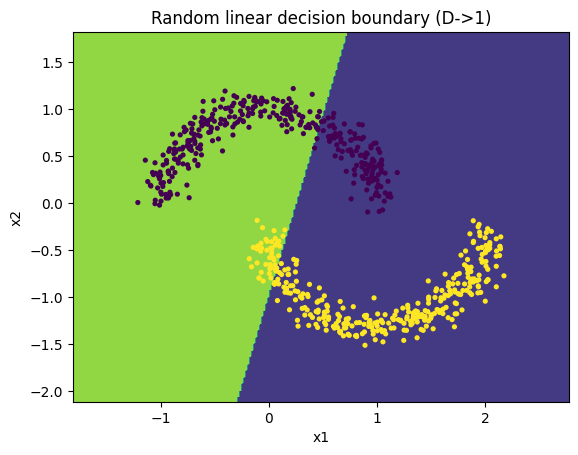

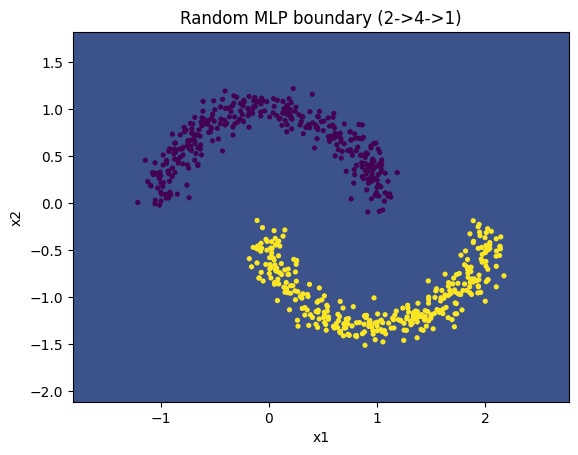

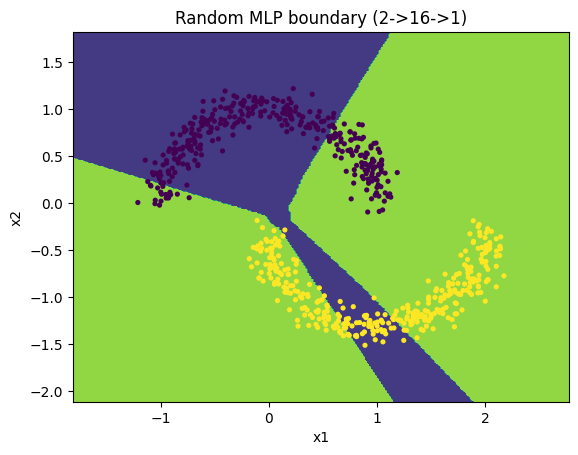

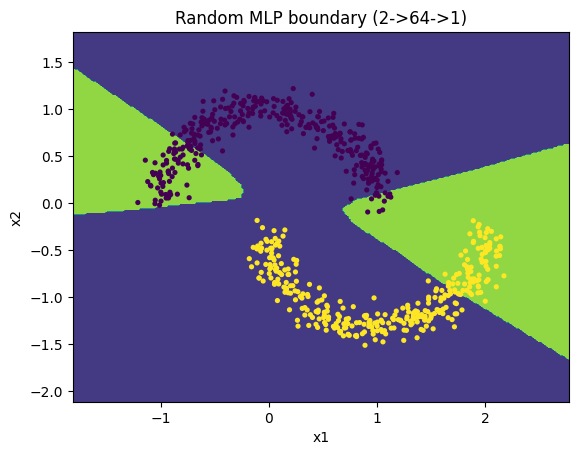

In [2]:
def param_count_dense(D_in, D_out):
    return D_in*D_out + D_out

def param_count_mlp(D, H, C):
    return param_count_dense(D, H) + param_count_dense(H, C)

architectures = [
    {'name': 'Linear (D->1)', 'D': 2, 'H': 0, 'C': 1},
    {'name': 'MLP (2->4->1)', 'D': 2, 'H': 4, 'C': 1},
    {'name': 'MLP (2->16->1)', 'D': 2, 'H': 16, 'C': 1},
    {'name': 'MLP (2->64->1)', 'D': 2, 'H': 64, 'C': 1},
]

for a in architectures:
    if a['H'] == 0:
        p = param_count_dense(a['D'], a['C'])
    else:
        p = param_count_mlp(a['D'], a['H'], a['C'])
    print(a['name'], 'params =', p)

def score_linear(u, rng):
    W = rng.normal(0, 1.0, size=(2,1))
    b = rng.normal(0, 0.2, size=(1,1))
    return (u @ W + b)[:,0]

def score_mlp(u, H, rng):
    W1 = rng.normal(0, 1.0, size=(2,H))
    b1 = rng.normal(0, 0.2, size=(1,H))
    W2 = rng.normal(0, 1.0, size=(H,1))
    b2 = rng.normal(0, 0.2, size=(1,1))
    z1 = u @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    return z2[:,0]

def plot_regions(x, y, score_fn, title):
    x1_min, x1_max = x[:,0].min()-0.6, x[:,0].max()+0.6
    x2_min, x2_max = x[:,1].min()-0.6, x[:,1].max()+0.6
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 250), np.linspace(x2_min, x2_max, 250))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    s = score_fn(grid).reshape(xx1.shape)
    plt.figure()
    plt.contourf(xx1, xx2, s > 0, levels=2)
    plt.scatter(x[:,0], x[:,1], c=y[:,0], s=14, edgecolors='none')
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

# Plot 1: linear
plot_regions(x, y, lambda u: score_linear(u, rng), 'Random linear decision boundary (D->1)')

# Plot 2: MLP widths
plot_regions(x, y, lambda u: score_mlp(u, 4, rng), 'Random MLP boundary (2->4->1)')
plot_regions(x, y, lambda u: score_mlp(u, 16, rng), 'Random MLP boundary (2->16->1)')
plot_regions(x, y, lambda u: score_mlp(u, 64, rng), 'Random MLP boundary (2->64->1)')

## Reflection questions
1. Why does width increase boundary complexity even with one hidden layer?
2. If you need multiclass classification with `C=3`, what changes in output shapes?
3. What are the trade-offs of increasing width vs increasing depth?
4. Why is parameter count only a proxy (not a guarantee) for overfitting?
5. What is your default “smallest reasonable” architecture for a 2D toy problem, and why?

## Optional extensions
1. Add a second hidden layer (2->H1->H2->1) and compare boundaries.
2. Replace ReLU with tanh and compare smoothness.
3. Compute and print parameter counts for multiclass outputs (e.g., C=3) and discuss memory/latency.

## Summary
- IO shapes define the model interface.
- Architecture choices change capacity and the geometry of possible boundaries.
- Parameter counts help compare options quickly.
- Visual boundaries help you sanity-check design choices.
- Next: activations and losses (and why pairings matter).